# 2021-02-11_EcN_NEB10B_TransformationEfficiency_LBnosalt_vs_SOB

## Protocol
### Not confirmed yet with Brandon
    - Tested EcN and NEB10B in LB no salt and SOB media 
    - EcN (LB no salt)
        * Diluted 1:50 from overnight into 25 mL, grew for 1 hour 40 minutes
        * Centrifuged and washed 3 times with ice-cold 10% glycerol
        * Resuspended in 100 uL ice-cold 10% glycerol
        * Transformed in 1, 5, or 10 ug of integrase and pAJT196 (<- that right plasmid???)
        * Add 400 uL of SOC to recover 
        * Place at 30C shaking for 1 hour
        * Plate on selective media
        * Also measure number of cells going into transformation by making serial 10-fold dilutions of comp. cells, spotting ?? uL onto non-selective media, and counting colonies at the dilution that yielded colonies. Multiplied by appropriate dilution factor of spot that showed colonies

In [1]:
# Matplotlib interactivity
#matplotlib notebook
import matplotlib
matplotlib.rc('figure', dpi = 160)
matplotlib.rcParams['pdf.fonttype'] = 42 # for making font editable when exported to PDF for Illustrator
matplotlib.rcParams['ps.fonttype'] = 42 # for making font editable when exported to PS for Illustrator

# Set the default sans-serif font to Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Set to always use sans-serif fonts
matplotlib.rcParams['font.family'] = "sans-serif"

In [25]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import cytoflow as flow
import string
import pandas as pd
import pickle
from scipy.optimize import least_squares
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import scipy
from scipy.optimize import curve_fit
import seaborn as sns


# Dan's custom scripts that aid in importing from conditions.csv file
sys.path.append('/Users/atriassi/Documents/MIT Dropbox (local)/Voigt Lab/_Data/Flow Cytometry Data/cytoflow_example_fromDan/modules')
import cf_imports
import cf_helpers

In [3]:
# Import reloads for when modules are being changed
import importlib
importlib.reload(cf_imports)
importlib.reload(cf_helpers)

<module 'cf_helpers' from '/Users/atriassi/Documents/MIT Dropbox (local)/Voigt Lab/_Data/Flow Cytometry Data/cytoflow_example_fromDan/modules/cf_helpers.py'>

## Data Import

In [4]:
# Renaming the file as "file"
file = '/Users/atriassi/Documents/MIT Dropbox (local)/Voigt Lab/_Data/Transformation Efficiency Data/2021-02-11_EcN_NEB10B_TransformationEfficiency_LBnosalt_vs_SOB.xlsx'
sheets = ['tidy']

# Another way to get data as dataframe
xl_data = pd.read_excel(file, sheet_name = sheets, header = 0, fill_value = 0)


In [5]:
xl_data['tidy']

,strain,media,dna_conc,rep,colonies,cfu_per_ml
0,AJT202,SOB,1,1,0,300000
1,AJT202,SOB,5,1,0,0
2,AJT202,SOB,10,1,0,0
3,AJT202,LB no salt,1,1,43,800000
4,AJT202,LB no salt,5,1,91,0
5,AJT202,LB no salt,10,1,48,0
6,NEB10B,SOB,1,1,93,700000
7,NEB10B,SOB,5,1,43,0
8,NEB10B,SOB,10,1,9,0
9,NEB10B,LB no salt,1,1,4200,600000


In [6]:
strains = sorted(xl_data['tidy']['strain'].unique())
media = sorted(xl_data['tidy']['media'].unique())
dna_conc = sorted(xl_data['tidy']['dna_conc'].unique())
rep = sorted(xl_data['tidy']['rep'].unique())

print(strains,media,dna_conc,rep)

['AJT202', 'NEB10B'] ['LB no salt', 'SOB'] [1, 5, 10] [1, 2, 3]


In [7]:
xl_data['tidy'][(xl_data['tidy']['strain']=='AJT202') & (xl_data['tidy']['rep']==1)]

,strain,media,dna_conc,rep,colonies,cfu_per_ml
0,AJT202,SOB,1,1,0,300000
1,AJT202,SOB,5,1,0,0
2,AJT202,SOB,10,1,0,0
3,AJT202,LB no salt,1,1,43,800000
4,AJT202,LB no salt,5,1,91,0
5,AJT202,LB no salt,10,1,48,0


In [8]:
data_dict_colonies = dict()
data_dict_cfu = dict()

for s in strains:
    data_dict_colonies[s] = dict()
    data_dict_cfu[s] = dict()
    for m in media:
        data_dict_colonies[s][m] = dict()
        data_dict_cfu[s][m] = dict()
        for d in dna_conc:
            data_dict_colonies[s][m][d] = dict()
            data_dict_cfu[s][m][d] = dict()
            for r in rep:
                
                q = xl_data['tidy'].query('strain == "{}"'.format(s) 
                                               + ' and ' + 'media == "{}"'.format(m)
                                              + ' and ' + 'dna_conc == {}'.format(d)
                                            + ' and ' + 'rep == "{}"'.format(r))
    #             print(q)

                data_dict_colonies[s][m][d][r] = q['colonies'].values[0]
                data_dict_cfu[s][m][d][r] = q['cfu_per_ml'].values[0]
        

    #             data_dict[s][t][r] = growth_data['tidy'][(growth_data[sheet]['Strain number'] == s)&(growth_data[sheet]['time']==t)]['od600'].values[0]
        
        
# make dictionary of dataframes beacuse dataframes look nicer
data = dict()

for s in strains:
    data[s] = dict()
    for m in media:
        data[s][m] = dict()
        data[s][m]['colonies'] = pd.DataFrame.from_dict(data_dict_colonies[s][m])
        data[s][m]['cfu'] = pd.DataFrame.from_dict(data_dict_cfu[s][m])


In [9]:
data['NEB10B']['LB no salt']['colonies'][1]

1     4200
2     3300
3    17000
Name: 1, dtype: int64

In [28]:
# parent = ['EcN']

In [14]:
# # dictionary with strain information that can be copied from experiment to experiment
# strain_info = dict([('AJT202', {'color': 'darkgrey', 
#                                'parent': 'EcN'}),
#                     ('NEB10B', {'color': '#FC4A1A', 
#                                'parent': 'EcN'})])

In [15]:
# plot_info = dict()

# for r in reps:
#     if r == 'r1':
#         plot_info[r] = {'marker': 'o',
#                            'facecolor': 'white',
#                            'edgecolor': 'black',
#                            'linecolor': 'black'}
# #                                'edgecolor': 'darkgrey',
# #                                'linecolor': 'darkgrey'}
#     elif r == 'r2':
#         plot_info[r] =  {'marker': 'o',
#                            'facecolor': 'white',
#                             'edgecolor': 'darkgrey',
# #                                'edgecolor': inducer_info[i]['color'],
#                            'linecolor': 'darkgrey'}

#     elif r == 'r3':
#         plot_info[r] =  {'marker': 'o',
# #                                'facecolor': inducer_info[i]['color'],
#                            'facecolor': 'white',
#                             'edgecolor': 'lightgrey',
#                             'linecolor': 'lightgrey'}
# #                                'edgecolor': 'k',
# #                                 'linecolor': 'k'}
# #                                'linecolor': inducer_info[i]['color']}

In [16]:
# plot_info['r1']

{'marker': 'o',
 'facecolor': 'white',
 'edgecolor': 'black',
 'linecolor': 'black'}

In [32]:
# list(filtered[filtered['parent_strain']=='AJT207']['strain_num'].unique())[0]

In [17]:
# fig_pos = {'EcN': {'fig_row': 0, 'fig_col': 0},
#  'AJT202': {'fig_row': 0, 'fig_col': 1},
#  'AJT206': {'fig_row': 0, 'fig_col': 2}}
# # fig_pos = dict()

# # for i in inducers:
# #     fig_pos[i] = {'fig_row': inducers.index(i)//2, 'fig_col': inducers.index(i)-(2*(inducers.index(i)//2))}

# fig_pos

{'EcN': {'fig_row': 0, 'fig_col': 0},
 'AJT202': {'fig_row': 0, 'fig_col': 1},
 'AJT206': {'fig_row': 0, 'fig_col': 2}}

In [10]:
data['NEB10B']['SOB']['colonies'][1]/data['NEB10B']['SOB']['cfu'][1]

1    0.000133
2    0.000203
3    0.000056
Name: 1, dtype: float64

## Plot

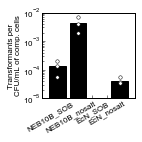

In [30]:
rows = 1
cols = 1

fig, ax = plt.subplots(rows,cols, figsize=(2*cols,1.8*rows)) # row, column format
plt.tight_layout() #tidies up spacing between plots

# ## make borders black (https://stackoverflow.com/questions/7778954/elegantly-changing-the-color-of-a-plot-frame-in-matplotlib)
# for spine in ax.spines.values():
#     spine.set_edgecolor('k')

FP = ax

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

    
y_data = [(data['NEB10B']['SOB']['colonies'][1]/data['NEB10B']['SOB']['cfu'][1]),
          (data['NEB10B']['LB no salt']['colonies'][1]/data['NEB10B']['LB no salt']['cfu'][1]),
          (data['AJT202']['SOB']['colonies'][1]/data['AJT202']['SOB']['cfu'][1]), 
          (data['AJT202']['LB no salt']['colonies'][1]/data['AJT202']['LB no salt']['cfu'][1])]

    
y_data_mean = [np.mean(data['NEB10B']['SOB']['colonies'][1]/data['NEB10B']['SOB']['cfu'][1]),
          np.mean(data['NEB10B']['LB no salt']['colonies'][1]/data['NEB10B']['LB no salt']['cfu'][1]),
          np.mean(data['AJT202']['SOB']['colonies'][1]/data['AJT202']['SOB']['cfu'][1]), 
          np.mean(data['AJT202']['LB no salt']['colonies'][1]/data['AJT202']['LB no salt']['cfu'][1])]

y_error = [np.std(data['NEB10B']['SOB']['colonies'][1]/data['NEB10B']['SOB']['cfu'][1]),
          np.std(data['NEB10B']['LB no salt']['colonies'][1]/data['NEB10B']['LB no salt']['cfu'][1]),
          np.std(data['AJT202']['SOB']['colonies'][1]/data['AJT202']['SOB']['cfu'][1]), 
          np.std(data['AJT202']['LB no salt']['colonies'][1]/data['AJT202']['LB no salt']['cfu'][1])]

for i, d in enumerate(y_data):

    FP.scatter([i+1]*len(d), d, 
                color = 'white', zorder = 2, s=12,
                edgecolor = 'black', linewidth = 0.5)


FP.bar([1,2,3,4], y_data_mean,# yerr = y_error, 
            color = 'black', zorder = 1, 
            edgecolor = 'black', linewidth = 1)#, 
#             error_kw=dict(lw=1, capsize=4, capthick=1, ecolor = 'black'))

# print(pd.Series(xdata_RPUg))
# print(pd.Series(data_RPUg))
# print(pd.concat((pd.Series(xdata_RPUg), pd.Series(data_RPUg)), axis = 1))

# sns.swarmplot(data = pd.concat((pd.Series(xdata_RPUg), pd.Series(data_RPUg)), axis = 1), 
#               ax = ax_RPUg, size = 10, color = 'white', edgecolor = 'black', linewidth = 2)

FP.set_xscale('linear')
FP.set_yscale('log')

FP.set_xlim(0.25,4.75)
FP.set_ylim(0.00001,0.01)

FP.set_ylabel('Transformants per\nCFU/mL of comp. cells', size = 8, color = 'black', labelpad = 2)
FP.yaxis.label.set_color('black')

FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2, colors = 'black')
FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in', colors = 'black')
FP.set_xticks([0.675,1.675,2.675,3.4])
FP.set_xticklabels(['NEB10B_SOB','NEB10B_nosalt','EcN_SOB','EcN_nosalt'], rotation = 30)
FP.grid(False)

# # adding RPUG label and arrow
# ax_RPUg.arrow(2.75,means['au']['AJT280'],-0.5,0, 
#               head_width=200, head_length=0.2, width = 50,
#               fc='black', ec='black', clip_on = False) # clip_on = False allows it to continue outside of axes
# ax_RPUg.text(2.8, means['au']['AJT280'], 
#              ('1 RPU$_{\mathrm{G}}$' +'\n({} a.u.)'.format(round(means['au']['AJT280'], 2))), # \mathrm gets rid of italics of Latex font, which is created by the $...$ for making subscript
#              verticalalignment = 'center', horizontalalignment = 'left', 
#              fontsize = 30, color = 'black')

# #autofluorescence label and arrow
# ax_RPUg.plot([0.25,1.75],[means['au']['AJT206'], means['au']['AJT206']], 
#               linestyle = '--', linewidth = 4, color = 'lightgrey')

# ax_RPUg.arrow(2.75,means['au']['AJT206'],-0.5,0, 
#               head_width=8, head_length=0.2, width = 2,
#               fc='black', ec='black', clip_on = False) # clip_on = False allows it to continue outside of axes
# ax_RPUg.text(2.8, means['au']['AJT206'], 
#              ('Autofluor.' +'\n({} a.u.)'.format(round(means['au']['AJT206'], 2))), 
# #              ('Autofluor.' +' {} a.u.'.format(round(means['au']['AJT206'], 2))), 
#              verticalalignment = 'center', horizontalalignment = 'left', 
#              fontsize = 30, color = 'black')


In [31]:
# fig.savefig('Fig1D_TransformationEfficiency_EcN_vs_NEB10B_LBnosalt_vs_SOB.pdf', bbox_inches = "tight", transparent = True)


In [39]:
y_data

[0.00013068571428571428, 0.004337962962962963, 0.0, 4.1805555555555556e-05]

In [37]:
stdevs['EcN']

0    0.000000
1    0.003303
2    0.004922
3    0.011865
4    0.071412
6    0.171177
8    0.140508
dtype: float64

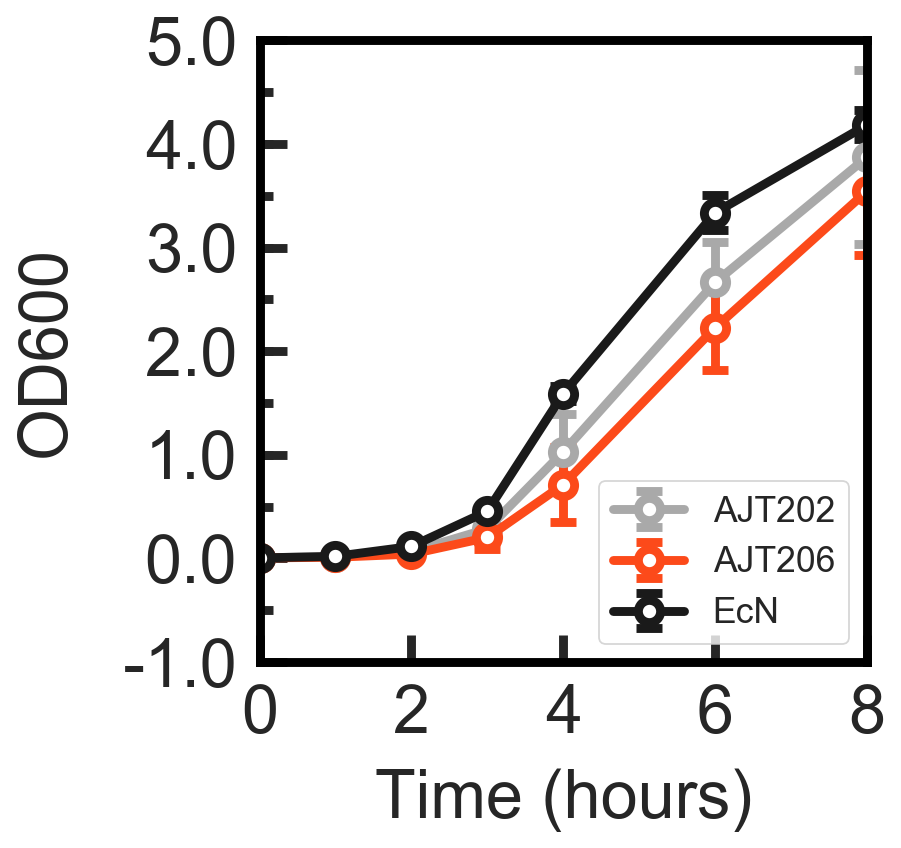

In [20]:
## plot 

fig2, ax2 = plt.subplots(1,1, figsize=(7.5,7.5), sharey = 'row') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


FP = ax2 # creating variable so don't have to change ax reference through whole loop

for spine in FP.spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(4)

for s in strains:

    ## scatter
    FP.errorbar(time, means[s], yerr = stdevs[s],
         ms = 10, marker = 'o', linestyle = '-', lw = 4,
            color = strain_info[s]['color'],
            mec = strain_info[s]['color'],
            mfc = 'white', mew = 4, 
            elinewidth = 4, capsize = 6,
            label = s)

    FP.set_yscale('linear')
    FP.set_xscale('linear')

    FP.set_ylabel('OD600', size = 30, labelpad = 20)

    FP.set_xlabel('Time (hours)', size = 30, labelpad = 10) 

    FP.tick_params(labelsize = 30, length = 12, width = 4, direction = 'in', pad = 10)
    FP.tick_params(which='minor', length = 6, width = 4, direction = 'in')
    FP.set_ylim(-1,5)
    FP.set_xlim(0,8)

    FP.yaxis.set_major_locator(MultipleLocator(1))
    FP.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # %.1f = one decimal point, %.2f = two decimal points
    FP.yaxis.set_minor_locator(MultipleLocator(0.5))

    FP.xaxis.set_major_locator(MultipleLocator(2))
    FP.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    FP.yaxis.grid(False)
    FP.xaxis.grid(False)

    FP.legend(markerscale = 1, fontsize = 16, bbox_to_anchor = (1,0), loc = 'lower right')


# # gets rid of empty plots
# fig.delaxes(ax[1,2]) # zero indexing
# fig.delaxes(ax[2,2]) # zero indexing


In [39]:
# fig2.savefig('GrowthCurves_ErrorBars.pdf', bbox_inches = "tight", transparent = True)


# Modeling growth using logistic and Gompertz equations
Reference: https://aem.asm.org/content/aem/56/6/1875.full.pdf

In [21]:
data

{'AJT202':         0         1         2         3         4        6        8
 r1  0.005  0.014418  0.079996  0.348918  1.230340  3.10909  4.81819
 r2  0.005  0.008606  0.034764  0.163180  0.610492  2.51379  3.57320
 r3  0.005  0.031021  0.083604  0.341844  1.246200  2.37132  3.22957,
 'AJT206':         0         1         2         3         4        6        8
 r1  0.005  0.012796  0.053389  0.274838  0.866833  2.61262  4.21923
 r2  0.005  0.007615  0.017904  0.079913  0.302177  1.80437  3.01683
 r3  0.005  0.013862  0.054728  0.251893  0.970287  2.26492  3.40249,
 'EcN':         0         1         2         3        4        6        8
 r1  0.005  0.015974  0.110347  0.459636  1.53991  3.49587  4.28917
 r2  0.005  0.021589  0.119553  0.465099  1.67226  3.35946  4.23889
 r3  0.005  0.021796  0.117968  0.442368  1.55959  3.15573  4.02459}

In [22]:
t_minutes = [t * 60 for t in time]
print(t_minutes)

[0, 60, 120, 180, 240, 360, 480]


In [23]:
data['EcN'].loc['r1',:]

0    0.005000
1    0.015974
2    0.110347
3    0.459636
4    1.539910
6    3.495870
8    4.289170
Name: r1, dtype: float64

In [24]:
### different functions to model the growth curve ########################
# t: time, A: max ln(OD), r: specific growth rate, lag: lag time
def func1(t, A, r, lag):
    return A / (1 + np.exp((4 * r * (lag - t)/A) + 2)) # logistic equation

def func2(t, A, r, lag):
    return A * np.exp(-np.exp(r * np.exp(1) * (lag - t)/A + 1)) # Gompertz equation
##########################################################################

OD_min = dict()
OD_log = dict()
results = dict()
pcov = dict()
fit_params = dict()

OD_means_min = dict()
OD_means_log = dict()
results_means = dict()
pcov_means = dict()
fit_params_means = dict()

for s in strains:
    OD_min[s] = dict()
    OD_log[s] = dict()
    results[s] = dict()
    pcov[s] = dict()
    fit_params[s] = dict()
    
    OD_means = means[s]
    OD_means_min[s] = OD_means.min()
    OD_means_log[s] = np.log(OD_means/OD_means_min[s])
    
    # curve fit the test data
    # use max ln(OD) as the initial guess of A
    # initial guess of r (0.02 <= 0.693/expected doubling time) and lag (120) was from inspecting the data
    A_init_means = OD_means_log[s].max()
    initial_guess_means = [A_init_means, 0.02, 120]
        # results, pcov = curve_fit(func1, t, OD_log, initial_guess) # logistic eqn
    results_means[s], pcov_means[s] = curve_fit(func2, t_minutes, OD_means_log[s], initial_guess_means) # Gompertz eqn

    # results is a list containing fitted parameter [A, r, lag] 
    fit_params_means[s] = {'max_OD': results_means[s][0],
                        'growth_rate': results_means[s][1],
                        'lag_time': results_means[s][2],
                        'double_time': np.log(2)/(results_means[s][1]), # results[s][r][1] = growth_rate

                        # get standard error
                        'std_err': np.sqrt(np.diag(pcov_means[s])) # array listing standard error of growth_rate, lag_time, and double_time
                       }    
    
    for r in reps:
        
        # get lowest OD as N_0
        # normalize against N_0 and take natural log
        OD = data[s].loc[r,:]
        OD_min[s][r] = OD.min()
        OD_log[s][r] = np.log(OD/OD_min[s][r])
        
        
        # curve fit the test data
        # use max ln(OD) as the initial guess of A
        # initial guess of r (0.02 <= 0.693/expected doubling time) and lag (120) was from inspecting the data
        A_init = OD_log[s][r].max()
        initial_guess = [A_init, 0.02, 120]
            # results, pcov = curve_fit(func1, t, OD_log, initial_guess) # logistic eqn
        results[s][r], pcov[s][r] = curve_fit(func2, t_minutes, OD_log[s][r], initial_guess) # Gompertz eqn

        # results is a list containing fitted parameter [A, r, lag] 
        fit_params[s][r] = {'max_OD': results[s][r][0],
                            'growth_rate': results[s][r][1],
                            'lag_time': results[s][r][2],
                            'double_time': np.log(2)/(results[s][r][1]), # results[s][r][1] = growth_rate
                            
                            # get standard error
                            'std_err': np.sqrt(np.diag(pcov[s][r])) # array listing standard error of growth_rate, lag_time, and double_time
                           }    

In [142]:
## DOESN'T WORK YET because haven't figured out how to add append to create and append to an array within a dictionary

# params_list = ['max_OD','growth_rate','lag_time','double_time']

# r123_fit_params = dict()

# for s in strains:
#     r123_fit_params[s] = dict()
#     for r in reps:
#         for p in params_list:
#             try:
#                 np.append(r123_fit_params[s][p], fit_params[s][r][p])
#             except KeyError:
#                 r123_fit_params[s][p] = np.array([])
           

In [25]:
fit_params_means['EcN']

{'max_OD': 6.781129131328213,
 'growth_rate': 0.030993316174512873,
 'lag_time': 20.335028582802977,
 'double_time': 22.364408398800183,
 'std_err': array([1.25628462e-01, 1.73881625e-03, 6.03729659e+00])}

In [42]:
fit_params_means['AJT202']

{'max_OD': 6.774579150450966,
 'growth_rate': 0.026916994659263175,
 'lag_time': 22.25293594344393,
 'double_time': 25.75128424753046,
 'std_err': array([1.55837059e-01, 1.61480822e-03, 7.11687095e+00])}

In [43]:
fit_params_means['AJT206']

{'max_OD': 6.683551782757201,
 'growth_rate': 0.026747226482767717,
 'lag_time': 39.312774190701056,
 'double_time': 25.914731047217746,
 'std_err': array([7.64533023e-02, 7.83798929e-04, 3.39236926e+00])}

In [26]:
r123_fit_params

NameError: name 'r123_fit_params' is not defined

In [27]:
fit_params['EcN']

{'r1': {'max_OD': 6.797735324395922,
  'growth_rate': 0.03207571700842182,
  'lag_time': 26.70337914320562,
  'double_time': 21.609717418879587,
  'std_err': array([9.55653313e-02, 1.39574472e-03, 4.54957426e+00])},
 'r2': {'max_OD': 6.796693046310776,
  'growth_rate': 0.030867168693925206,
  'lag_time': 18.1991412527359,
  'double_time': 22.455806926547158,
  'std_err': array([1.42756694e-01, 1.95696345e-03, 6.86614717e+00])},
 'r3': {'max_OD': 6.739739668210105,
  'growth_rate': 0.030329263485576824,
  'lag_time': 17.121658448735637,
  'double_time': 22.85407230180758,
  'std_err': array([1.46598815e-01, 1.97637873e-03, 7.11149880e+00])}}

## Plotting modeled growth curves on ln(N/N_0) y-axis

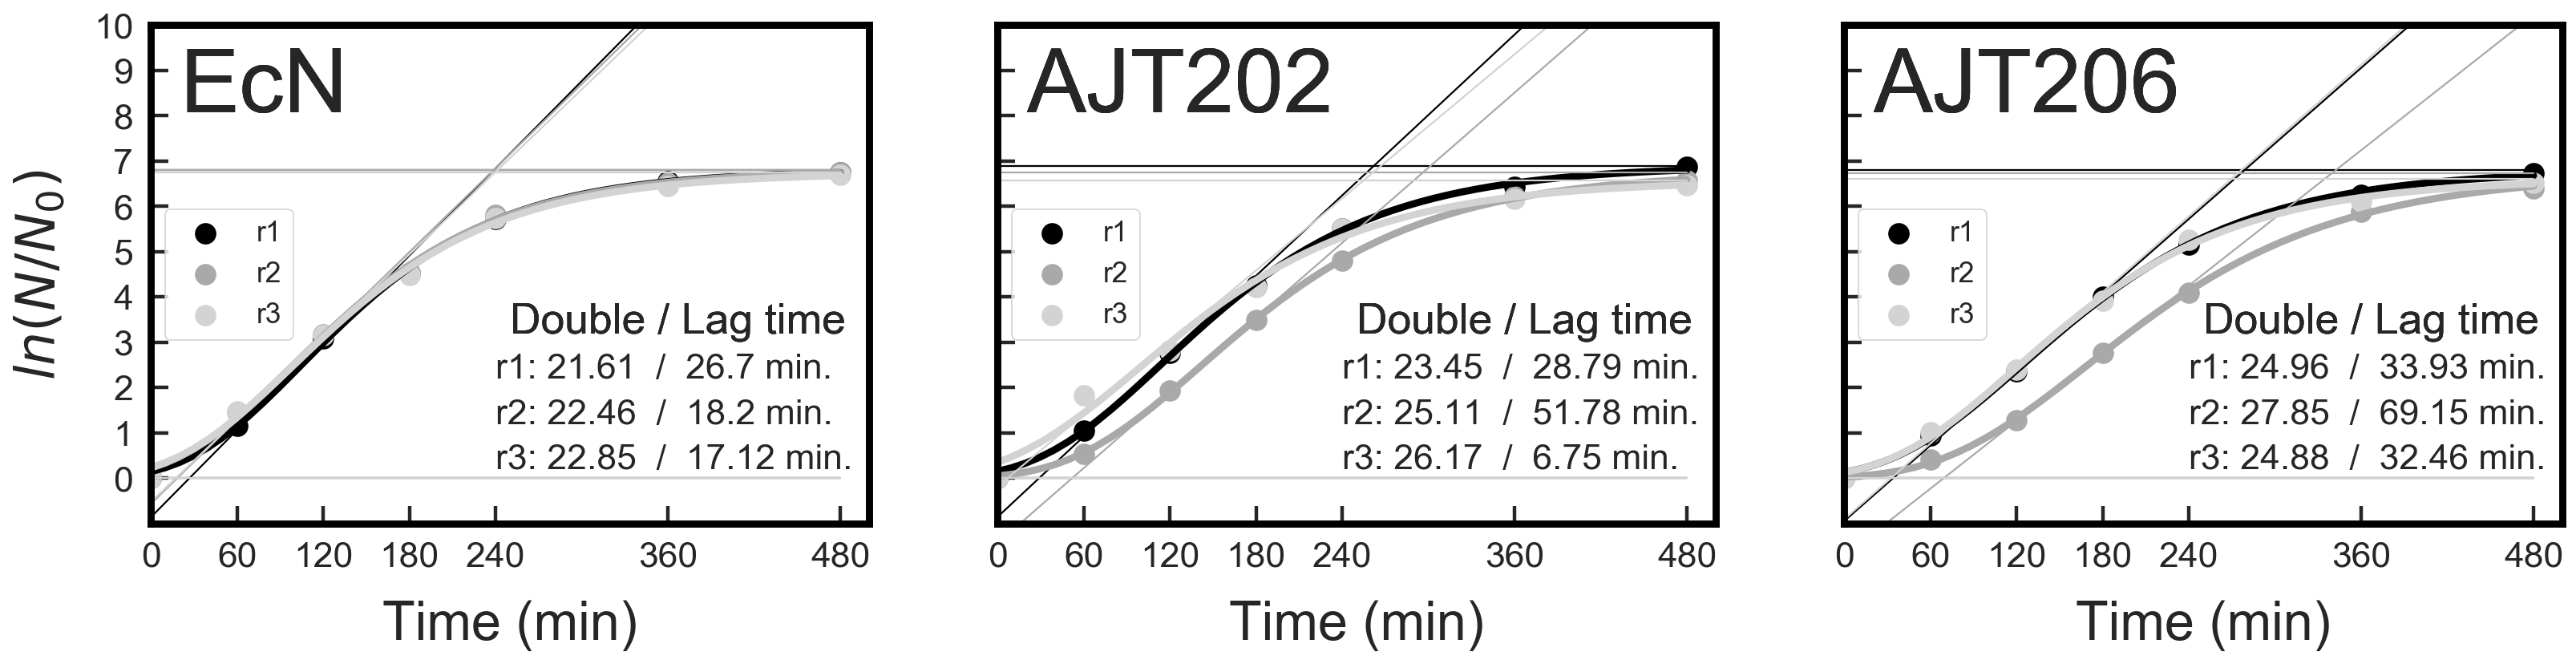

In [28]:
## plot growth curves of each replicate

fig3, ax3 = plt.subplots(1,3, figsize=(22.5,7.5), sharey = 'row', sharex = 'col') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


for s in strains:
    
    FP = ax3[fig_pos[s]['fig_col']]
    
    for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(4)

    for r in reps:
        
        ## scatter
        FP.scatter(t_minutes, OD_log[s][r],
                 s = 100, marker = plot_info[r]['marker'], # linestyle = '-', lw = 6,
                    color = plot_info[r]['linecolor'],
                    edgecolor = plot_info[r]['edgecolor'],
                    facecolor = plot_info[r]['edgecolor'], linewidth = 2, 
                    label = r)

        # create data for the fitted equation plot
        x = np.linspace(min(t_minutes), max(t_minutes))
        y = func2(x, *results[s][r]) # for plotting on y-axis of ln(N/N_0)
#         y = np.exp(func2(x, *results[s][r]))*OD_min[s][r] # for plotting on ya
        FP.plot(x, y, color = plot_info[r]['linecolor'], linewidth = 4)

        # draw lowest hightest boundary of ln(N/N_0)
        max_OD = fit_params[s][r]['max_OD']
        
        y_max = 0 * x + max_OD
        y_min = 0 * x
        FP.plot(x, y_max, color = plot_info[r]['linecolor'], linewidth = 1)
        FP.plot(x, y_min, color = plot_info[r]['linecolor'], linewidth = 1)

        # draw the fasted growth rate line
        # this line should pass (lag_time, 0) <= how the constant term came from
        growth_rate = fit_params[s][r]['growth_rate']
        lag_time = fit_params[s][r]['lag_time']
        
        y_maxrate = growth_rate * x - growth_rate * lag_time
        FP.plot(x, y_maxrate, color = plot_info[r]['linecolor'], linewidth = 1)

        # labels and limits
        FP.set_xlabel('Time (min)', size = 30, labelpad = 15)
        if fig_pos[s]['fig_col'] == 0:
            FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)
            
        FP.set_ylim(-1, 10)
        FP.set_xlim(0,500)
        
        FP.set_xticks(t_minutes)
        FP.set_yticks(range(11))
        
        FP.tick_params(labelsize = 20, length = 10, width = 2, direction = 'in', pad = 10)
        FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')

        FP.yaxis.grid(False)
        FP.xaxis.grid(False)
        FP.legend(markerscale = 1, fontsize = 16, loc = 'center left')
    #             ax[fig_pos[s]['fig_row']][fig_pos[s]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

        FP.text(20, 9.5, s, 
                  verticalalignment = 'top', horizontalalignment = 'left', 
                  fontsize = 50)
        
        FP.text(250,3.2,'Double / Lag time',fontsize = 24)
        FP.text(240,2.2 - reps.index(r), 
                '{}: {}  /  {} min.'.format(r, round(fit_params[s][r]['double_time'], 2), 
                                             round(fit_params[s][r]['lag_time'], 2)), fontsize = 20)
        
        

In [120]:
# fig3.savefig('GrowthCurves_timeXlnN-N0__CurveFit_EachReplicate.pdf', bbox_inches = "tight", transparent = True)

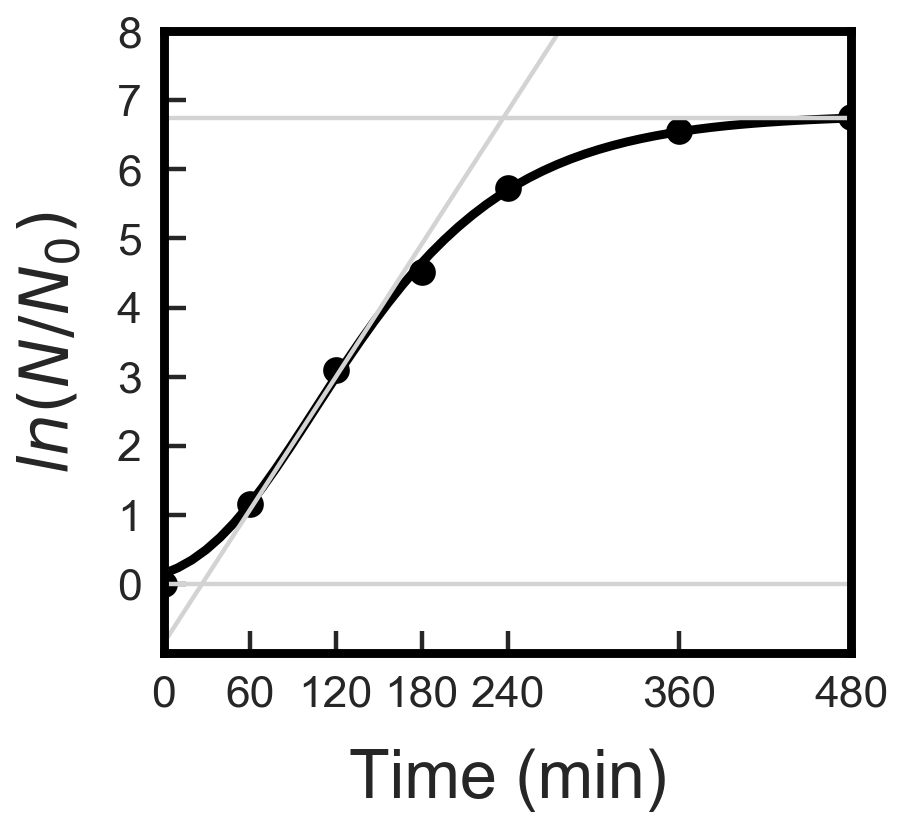

In [29]:
## sample plot to explain how doubling time was calculated

fig_demo, ax_demo = plt.subplots(1,1, figsize=(8,7.5), sharey = 'row', sharex = 'col') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots
 
FP = ax_demo

for spine in FP.spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(4)

## scatter
FP.scatter(t_minutes, OD_log['EcN']['r1'],
         s = 100, marker = 'o', # linestyle = '-', lw = 6,
            color = 'black',
            edgecolor = 'black',
            facecolor = 'black', linewidth = 2)

# create data for the fitted equation plot
x = np.linspace(min(t_minutes), max(t_minutes))
y = func2(x, *results['EcN']['r1']) # for plotting on y-axis of ln(N/N_0)
#         y = np.exp(func2(x, *results[s][r]))*OD_min[s][r] # for plotting on ya
FP.plot(x, y, color = 'black', linewidth = 4)

# draw lowest hightest boundary of ln(N/N_0)
max_OD = fit_params[s][r]['max_OD']

y_max = 0 * x + max_OD
y_min = 0 * x
FP.plot(x, y_max, color = 'lightgrey', linewidth = 2)
FP.plot(x, y_min, color = 'lightgrey', linewidth = 2)

# draw the fasted growth rate line
# this line should pass (lag_time, 0) <= how the constant term came from
growth_rate = fit_params['EcN']['r1']['growth_rate']
lag_time = fit_params['EcN']['r1']['lag_time']

y_maxrate = growth_rate * x - growth_rate * lag_time
FP.plot(x, y_maxrate, color = 'lightgrey', linewidth = 2)

# labels and limits
FP.set_xlabel('Time (min)', size = 30, labelpad = 15)
if fig_pos[s]['fig_col'] == 0:
    FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)

FP.set_ylim(-1, 8)
FP.set_xlim(0,480)

FP.set_xticks(t_minutes)
FP.set_yticks(range(9))

FP.tick_params(labelsize = 20, length = 10, width = 2, direction = 'in', pad = 10)
FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')

FP.yaxis.grid(False)
FP.xaxis.grid(False)
        
        

In [171]:
# fig_demo.savefig('GrowthCurve_Demonstration.pdf', bbox_inches = "tight", transparent = True)

## Plotting modeled growth curves on OD600 y-axis

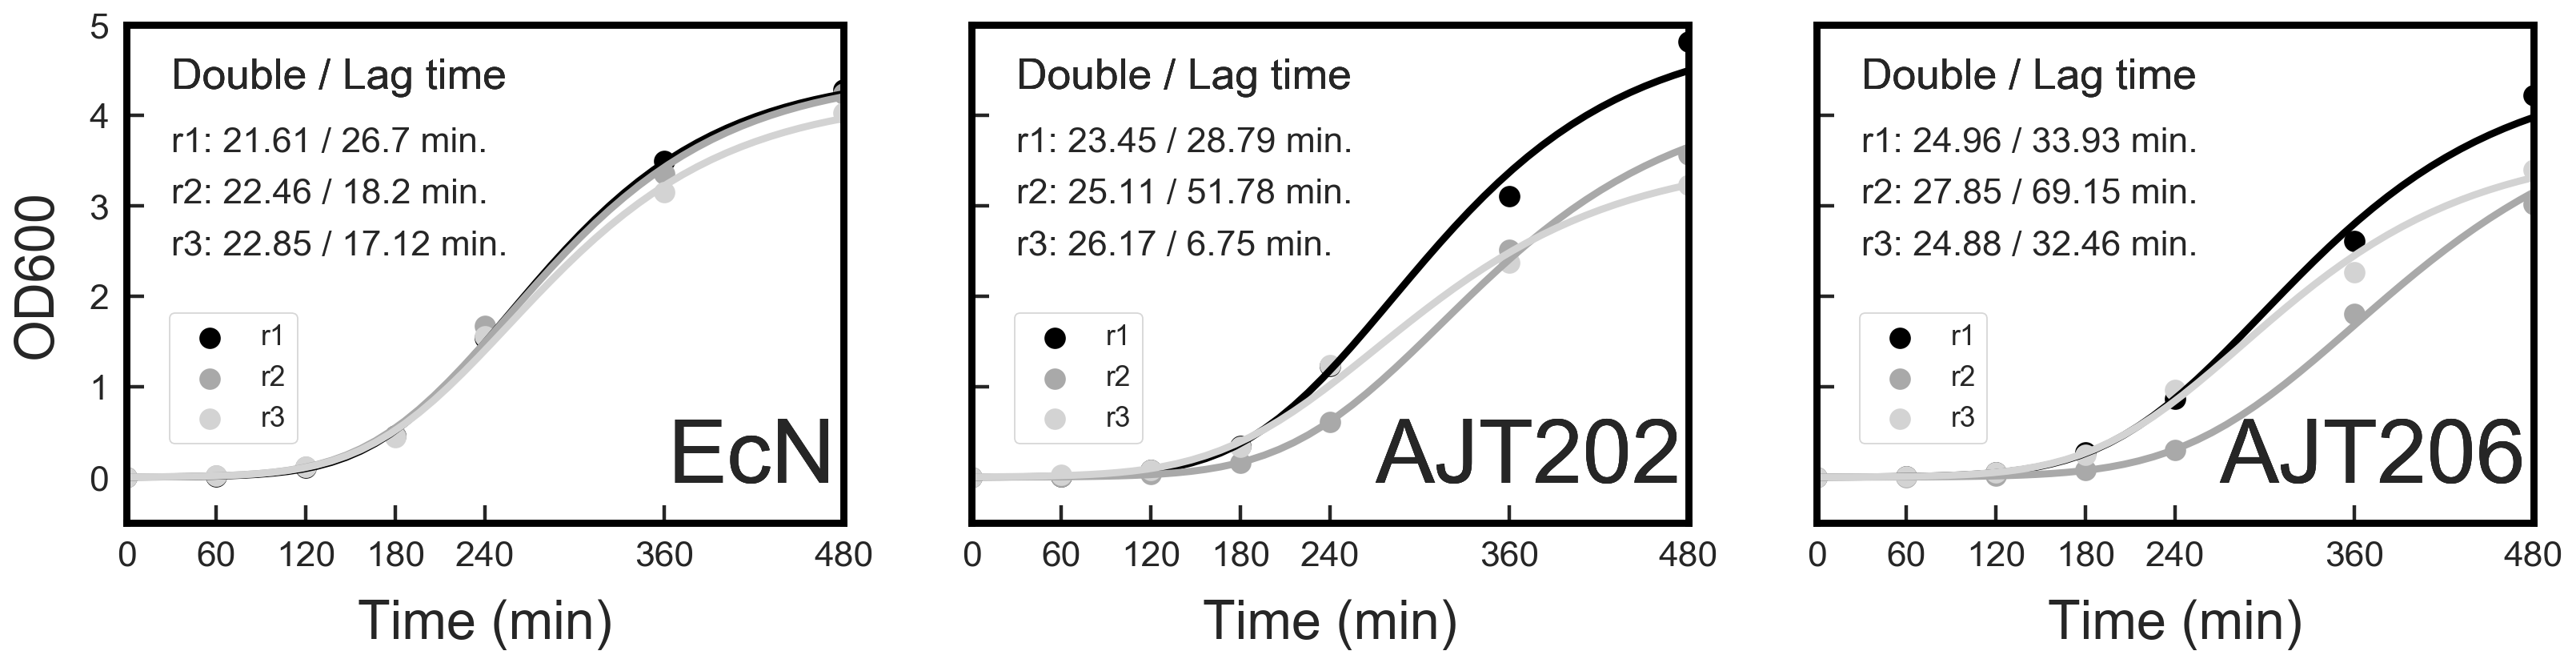

In [30]:
## plot growth curves of each replicate with OD600 as y-axis

fig4, ax4 = plt.subplots(1,3, figsize=(22.5,7.5), sharey = 'row', sharex = 'col') # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


for s in strains:
    
    FP = ax4[fig_pos[s]['fig_col']]
    
    for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(4)

    for r in reps:
        
        ## scatter
        OD = data[s].loc[r,:]
        
        FP.scatter(t_minutes, OD,
                 s = 100, marker = plot_info[r]['marker'], # linestyle = '-', lw = 6,
                    color = plot_info[r]['linecolor'],
                    edgecolor = plot_info[r]['edgecolor'],
                    facecolor = plot_info[r]['edgecolor'], linewidth = 2, 
                    label = r)

        # create data for the fitted equation plot
        x = np.linspace(min(t_minutes), max(t_minutes))
#         y = func2(x, *results[s][r]) # for plotting on y-axis of ln(N/N_0)
        y = np.exp(func2(x, *results[s][r]))*OD_min[s][r] # for plotting on y-axis of OD600
        FP.plot(x, y, color = plot_info[r]['linecolor'], linewidth = 4)

#         # draw lowest hightest boundary of ln(N/N_0)
#         max_OD = fit_params[s][r]['max_OD']
        
#         y_max = 0 * x + max_OD
#         y_min = 0 * x
#         FP.plot(x, y_max, color = plot_info[r]['linecolor'], linewidth = 1)
#         FP.plot(x, y_min, color = plot_info[r]['linecolor'], linewidth = 1)

#         # draw the fasted growth rate line
#         # this line should pass (lag_time, 0) <= how the constant term came from
#         growth_rate = fit_params[s][r]['growth_rate']
#         lag_time = fit_params[s][r]['lag_time']
        
#         y_maxrate = growth_rate * x - growth_rate * lag_time
#         FP.plot(x, y_maxrate, color = plot_info[r]['linecolor'], linewidth = 1)

        # labels and limits
        FP.set_xlabel('Time (min)', size = 30, labelpad = 15)
        if fig_pos[s]['fig_col'] == 0:
#             FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)
            FP.set_ylabel('OD600', size = 30, labelpad = 15)
            
        FP.set_ylim(-0.5, 5)
        FP.set_xlim(0,480)
        
        # ticks
        FP.set_xticks(t_minutes)
        FP.set_yticks(range(6))
        
        FP.tick_params(labelsize = 20, length = 10, width = 2, direction = 'in', pad = 10)
        FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')

        # turn off grid
        FP.yaxis.grid(False)
        FP.xaxis.grid(False)
        
        # legend
        FP.legend(markerscale = 1, fontsize = 16, bbox_to_anchor=(0.04,0.45), loc = 'upper left')
    #             ax[fig_pos[s]['fig_row']][fig_pos[s]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

        # text labels
        FP.text(475, -0.25, s, 
                  verticalalignment = 'bottom', horizontalalignment = 'right', 
                  fontsize = 50)
        
        FP.text(30,4.3,'Double / Lag time',fontsize = 24)
        FP.text(30,3.6 - reps.index(r)/1.75, 
                '{}: {} / {} min.'.format(r, round(fit_params[s][r]['double_time'], 2), 
                                             round(fit_params[s][r]['lag_time'], 2)), fontsize = 20)
        
        

In [119]:
# fig4.savefig('GrowthCurves_timeXod600_CurveFit_EachReplicate.pdf', bbox_inches = "tight", transparent = True)

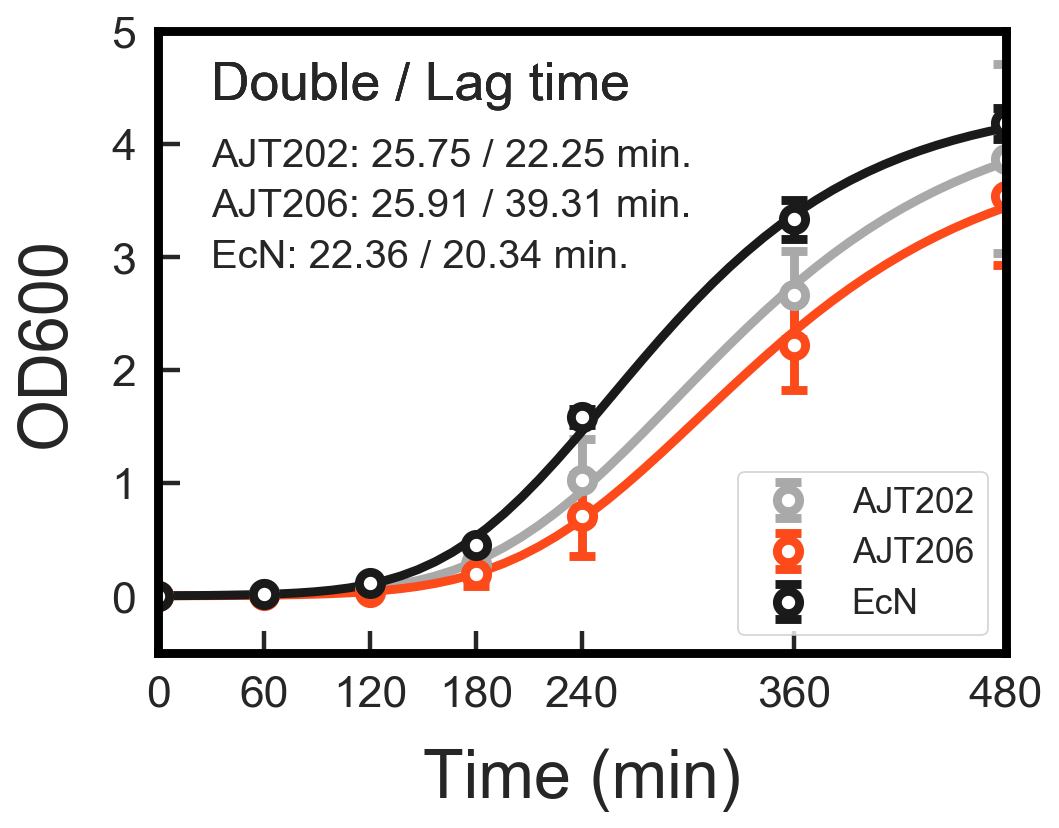

In [31]:
## plot growth curves of means with OD600 as y-axis

fig5, ax5 = plt.subplots(1,1, figsize=(9,7.5)) # row, column format
plt.tight_layout(pad = 12, h_pad = 10, w_pad = 6) #tidies up spacing between plots


for s in strains:
    
    FP = ax5
    
    for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(4)
        
    ## scatter
    OD = means[s]

    FP.errorbar(t_minutes, OD,
                yerr = stdevs[s],
                ms = 10, marker = 'o', linestyle = 'none',
                color = strain_info[s]['color'],
                mec = strain_info[s]['color'],
                mfc = 'white', mew = 4, 
                elinewidth = 4, capsize = 6,
                label = s)

    # create data for the fitted equation plot
    x = np.linspace(min(t_minutes), max(t_minutes))
#         y = func2(x, *results[s][r]) # for plotting on y-axis of ln(N/N_0)
    y = np.exp(func2(x, *results_means[s]))*OD_means_min[s] # for plotting on y-axis of OD600
    FP.plot(x, y, color = strain_info[s]['color'], linewidth = 4)

#         # draw lowest hightest boundary of ln(N/N_0)
#         max_OD = fit_params[s][r]['max_OD']

#         y_max = 0 * x + max_OD
#         y_min = 0 * x
#         FP.plot(x, y_max, color = plot_info[r]['linecolor'], linewidth = 1)
#         FP.plot(x, y_min, color = plot_info[r]['linecolor'], linewidth = 1)

#         # draw the fasted growth rate line
#         # this line should pass (lag_time, 0) <= how the constant term came from
#         growth_rate = fit_params[s][r]['growth_rate']
#         lag_time = fit_params[s][r]['lag_time']

#         y_maxrate = growth_rate * x - growth_rate * lag_time
#         FP.plot(x, y_maxrate, color = plot_info[r]['linecolor'], linewidth = 1)

    # labels and limits
    FP.set_xlabel('Time (min)', size = 30, labelpad = 15)
    if fig_pos[s]['fig_col'] == 0:
#             FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)
        FP.set_ylabel('OD600', size = 30, labelpad = 15)

    FP.set_ylim(-0.5, 5)
    FP.set_xlim(0,480)

    # ticks
    FP.set_xticks(t_minutes)
    FP.set_yticks(range(6))

    FP.tick_params(labelsize = 20, length = 10, width = 2, direction = 'in', pad = 10)
    FP.tick_params(which='minor', length = 5, width = 2, direction = 'in')

    # turn off grid
    FP.yaxis.grid(False)
    FP.xaxis.grid(False)

    # legend
    FP.legend(markerscale = 1, fontsize = 16, loc = 'lower right')# bbox_to_anchor=(0.04,0.45), loc = 'upper left')
#             ax[fig_pos[s]['fig_row']][fig_pos[s]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)

#     # text labels
#     FP.text(475, -0.25, s, 
#               verticalalignment = 'bottom', horizontalalignment = 'right', 
#               fontsize = 50)

    FP.text(30,4.4,'Double / Lag time',fontsize = 24)
    FP.text(30,3.8 - strains.index(s)/2.25, 
            '{}: {} / {} min.'.format(s, round(fit_params_means[s]['double_time'], 2), 
                                         round(fit_params_means[s]['lag_time'], 2)), fontsize = 18)

        

In [164]:
fig5.savefig('GrowthCurves_timeXod600_CurveFit_ErrorBars.pdf', bbox_inches = "tight", transparent = True)

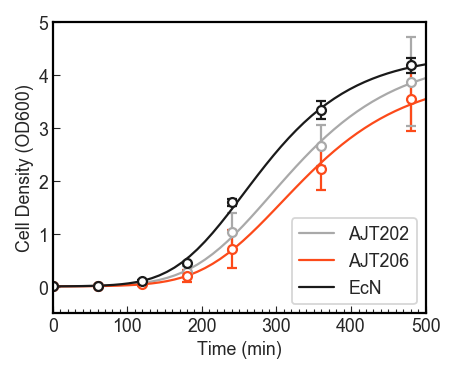

In [40]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

## plot growth curves of means with OD600 as y-axis

fig5_pub, ax5_pub = plt.subplots(1,1, figsize=(2.7,2.1)) # row, column format
plt.tight_layout(pad = 0) #tidies up spacing between plots


for s in strains:
    
    FP = ax5_pub
    
    for spine in FP.spines.values():
                        spine.set_edgecolor('black')
                        spine.set_linewidth(1)
        
    ## scatter
    OD = means[s]

    FP.errorbar(t_minutes, OD,
                yerr = stdevs[s],
                ms = 4, marker = 'o', linestyle = 'none',
                color = strain_info[s]['color'],
                mec = strain_info[s]['color'],
                mfc = 'white', mew = 1, 
                elinewidth = 1, capsize = 2.25, capthick = 1)

    # create data for the fitted equation plot
    x = np.linspace(min(t_minutes), 500)
#         y = func2(x, *results[s][r]) # for plotting on y-axis of ln(N/N_0)
    y = np.exp(func2(x, *results_means[s]))*OD_means_min[s] # for plotting on y-axis of OD600
    FP.plot(x, y, color = strain_info[s]['color'], linewidth = 1, label = s)

#         # draw lowest hightest boundary of ln(N/N_0)
#         max_OD = fit_params[s][r]['max_OD']

#         y_max = 0 * x + max_OD
#         y_min = 0 * x
#         FP.plot(x, y_max, color = plot_info[r]['linecolor'], linewidth = 1)
#         FP.plot(x, y_min, color = plot_info[r]['linecolor'], linewidth = 1)

#         # draw the fasted growth rate line
#         # this line should pass (lag_time, 0) <= how the constant term came from
#         growth_rate = fit_params[s][r]['growth_rate']
#         lag_time = fit_params[s][r]['lag_time']

#         y_maxrate = growth_rate * x - growth_rate * lag_time
#         FP.plot(x, y_maxrate, color = plot_info[r]['linecolor'], linewidth = 1)

    # labels and limits
    FP.set_xlabel('Time (min)', size = 8, labelpad = 2)
    if fig_pos[s]['fig_col'] == 0:
#             FP.set_ylabel('$ln(N/N_0)$', size = 30, labelpad = 15)
        FP.set_ylabel('Cell Density (OD600)', size = 8, labelpad = 2)

    FP.set_ylim(-0.5, 5)
    FP.set_xlim(0,500)

    # ticks
    x_major = matplotlib.ticker.MultipleLocator(base = 100)
    FP.xaxis.set_major_locator(x_major)
    
    x_minor = matplotlib.ticker.MultipleLocator(base = 10)
    FP.xaxis.set_minor_locator(x_minor)
    
    FP.set_yticks(range(6))

    FP.tick_params(labelsize = 8, length = 3, width = 0.5, direction = 'in', pad = 2)
    FP.tick_params(which='minor', length = 2, width = 0.5, direction = 'in')

    # turn off grid
    FP.yaxis.grid(False)
    FP.xaxis.grid(False)

    # legend
    FP.legend(markerscale = 1, fontsize = 8, loc = 'lower right')# bbox_to_anchor=(0.04,0.45), loc = 'upper left')
#             ax[fig_pos[s]['fig_row']][fig_pos[s]['fig_col']].legend.legendHandles._legmarker.set_markersize(50)



        

In [41]:
# fig5_pub.savefig('GrowthCurves_timeXod600_CurveFit_ErrorBars.pdf', bbox_inches = "tight", transparent = True)